# Comparing non-dp decision tree vs dp decision tree

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import diffprivlib.models as dp
from snsynth import Synthesizer

In [3]:
# Original data
maternal_health = pd.read_csv('maternalHealthDataSet.csv')
X = maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
y = maternal_health['RiskLevel']

## Method 0 (No noise added)

In [6]:
def dtree(X, y):
    clf = DecisionTreeClassifier()
    
    # Evaluate the model 
    accuracy = cross_val_score(clf, X, y, cv=10).mean()
    return accuracy

dtree(X, y)

0.8124344787419918

## Method 1 (BASE CASE) (DP Decision Tree, Original Data)

In [4]:
def dp_dtree(epsilon):
    classes = (0, 1, 2) # 0=low risk, 1=mid risk, 2=high risk
    
    # Bounds computer with publicly available domain knowlegde
    # Age, Systolic BP, Diastolic BP, BS, Body Temp, Heart Rate
    bounds = ([1, 50, 50, 60, 95, 60],[125, 170, 170, 130, 103, 100])
    
    
    dp_clf = dp.DecisionTreeClassifier(epsilon=epsilon, bounds=bounds, classes=classes)
    # Evaluate the model 
    accuracy = cross_val_score(dp_clf, X, y, cv=10).mean()
    return accuracy
    
dp_dtree(1.0)

0.4930887206367697

In [11]:
def create_synthesizer(epsilon, delta):
    # MST synthesizer is used here since it took 1st place in NIST's DP syntehtic data contest
    synth = Synthesizer.create("mst", epsilon=epsilon, delta=delta, verbose=True)
    synth.fit(maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']], preprocessor_eps=epsilon/5) # allocate 1/5 of epsilon to the preprocesser
    return synth

def dp_synth_dtree(synth, samples):
    data = synth.sample(samples)
    X_synth = data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
    y_synth = data['RiskLevel']
    return dtree(X_synth, y_synth)

## Effect of samples on models trained with synthetic data

In [14]:
synth_one = create_synthesizer(1.0, 1e-5)

/opt/anaconda3/lib/python3.12/site-packages/mbi/__init__.py:15: UserWarning: MixtureInference disabled, please install jax and jaxlib
  warnings.warn('MixtureInference disabled, please install jax and jaxlib')


Spent 0.2 epsilon on preprocessor, leaving 0.8 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals


In [16]:
# TODO: REPLACED BY CELLS BELOW
"""
samples = [10**n for n in range(3, 8)]
accuracies = []
for n in samples:
    accuracies.append(dp_synth_dtree(synth_one, n))
"""

'\nsamples = [10**n for n in range(3, 8)]\naccuracies = []\nfor n in samples:\n    accuracies.append(dp_synth_dtree(synth_one, n))\n'

In [17]:
#TODO: REPLACED BY CELLS BELOW
"""
plt.title("Model Accuracy vs. Samples")
plt.xscale("log")
plt.xlabel("Samples")
plt.ylabel("Model Accuracy")
plt.ylim(0, 1.0)

plt.axhline(dtree(X,y), color='r') # plot base accuracy of model
plt.plot(samples, , color='g') # plot accuracy of dp decision tree
plt.plot(samples, accuracies, color='b') # plot accuracy of dp synthetic data 
plt.legend([f'Non DP Model (n={len(X)})', r'$1.0$-DP Model', r'$1.0, 1e^{-5}$-DP Synthetic Data Model']) 
plt.show()
"""

'\nplt.title("Model Accuracy vs. Samples")\nplt.xscale("log")\nplt.xlabel("Samples")\nplt.ylabel("Model Accuracy")\nplt.ylim(0, 1.0)\n\nplt.axhline(dtree(X,y), color=\'r\') # plot base accuracy of model\nplt.plot(samples, , color=\'g\') # plot accuracy of dp decision tree\nplt.plot(samples, accuracies, color=\'b\') # plot accuracy of dp synthetic data \nplt.legend([f\'Non DP Model (n={len(X)})\', r\'$1.0$-DP Model\', r\'$1.0, 1e^{-5}$-DP Synthetic Data Model\']) \nplt.show()\n'

## Compare Model Accuracy to Training Dataset Size

### Create two synthesizers for each pipeline
The synthesizer `big_synth` has `epsilon = 1000` which provides essentially no privacy garuntee by design. This is because this synthetic data is fed into the Differentially Private Decision Tree Classifier which has `epsilon = 1.0`, which is equivalent to the `epsilon` value used in the other pipeline

In [5]:
# Create Synthesizer
synth = Synthesizer.create("mst", epsilon=1.0, delta=1e-5, verbose=True)
synth.fit(maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']], preprocessor_eps=1.0/5) # allocate 1/5 of epsilon to the preprocesser

# Unbounded Synthesizer
# Create Synthesizer with unbounded epsilon and delta = 1e-5
massive_epsilon = 100000
big_synth = Synthesizer.create("mst", epsilon=massive_epsilon, delta=1e-5, verbose=True)
big_synth.fit(maternal_health[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel']], preprocessor_eps=massive_epsilon/3) # allocate 1/3 of epsilon to the preprocesser


Spent 0.2 epsilon on preprocessor, leaving 0.8 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals


c:\Users\jack\OneDrive\Desktop\cs3110\cs3110-final-project\.venv\Lib\site-packages\snsql\sql\odometer.py:79: RuntimeWarning: overflow encountered in exp
  optimal_left_side = np.sum([((np.exp(eps) - 1) * eps) / ((np.exp(eps) + 1)) for eps, _ in self.steps])
c:\Users\jack\OneDrive\Desktop\cs3110\cs3110-final-project\.venv\Lib\site-packages\snsql\sql\odometer.py:79: RuntimeWarning: invalid value encountered in scalar divide
  optimal_left_side = np.sum([((np.exp(eps) - 1) * eps) / ((np.exp(eps) + 1)) for eps, _ in self.steps])


Spent 33333.333333333336 epsilon on preprocessor, leaving 66666.66666666666 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals


### Gather data points, seperated due to long running time

In [6]:
def noisy_synth_model(sample_amt, synthesizer):
    
    # Sample it and run it on regular decision tree
    syn_data = synthesizer.sample(sample_amt)
    X_synth = syn_data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
    y_synth = syn_data['RiskLevel']

    clf = DecisionTreeClassifier()
    
    # Evaluate the model 
    accuracy = cross_val_score(clf, X_synth, y_synth, cv=10).mean()
    return accuracy

def noisy_tree_model(epsilon, sample_amt, synthesizer):
    
    # Sample it and run it on DP decision tree
    syn_data = synthesizer.sample(sample_amt)
    X_synth = syn_data[['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']]
    y_synth = syn_data['RiskLevel']

    classes = (0, 1, 2) # 0=low risk, 1=mid risk, 2=high risk
    
    # Bounds computer with publicly available domain knowlegde
    # Age, Systolic BP, Diastolic BP, BS, Body Temp, Heart Rate
    bounds = ([1, 50, 50, 60, 95, 60],[125, 170, 170, 130, 103, 100])
    
    dp_clf = dp.DecisionTreeClassifier(epsilon=epsilon, bounds=bounds, classes=classes)
    # Evaluate the model 
    accuracy = cross_val_score(dp_clf, X_synth, y_synth, cv=10).mean()
    return accuracy

# Get accuracies for epsilon 1.0 and delta 1e-5
sample_range = [10**n for n in range(3, 7)]
noisy_synth_accuracies = []
noisy_tree_accuracies = []

for n in sample_range:
    noisy_synth_accuracies.append(noisy_synth_model(n, synth))
    noisy_tree_accuracies.append(noisy_tree_model(1.0, n, big_synth))

c:\Users\jack\OneDrive\Desktop\cs3110\cs3110-final-project\.venv\Lib\site-packages\snsynth\mst\mst.py:240: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1 44 48  5 14 39 15 48  4 38 11 17 29 28 35  9 42 15 44  1 29 30 48 29
 49  2 48 11 17 45 27 14  1 32  4 10 46 44 43 38 45 28  9 20  0 28 35 15
 46 35 14 38 42 35 22 35  0 44  2 22 38 24 16 30  7 28 40 14  6  2 23 32
 29 45 45  7  5 40 42 43 46 17 30 35 45 21 24 38  7 11 24  3 49 47 19 27
 34 40 38 41  7 38 16 29 47 47  2  4 17 46 21 17 41 26 43 24  3 34  7  2
 44 22 27 30 40  6 49 47  9  4 36  9  0 31  7 34 49 36 13  3 17 19 45 13
 45 23 36  6 42 26 38 28 26  2  6 49  3 37  0 22 14 47 39 14  3  7 47 38
 42 42 19 23 33 35 20 41 31 28  6 23 38 44 33 11  7 36 26 28 26 37  6 36
 31 14 23 41 17 41 45 27 27 23 20  7 41 26 14 21 35 47 28 24 25  7  0 16
 19 31 13 21 45 39 15 17  9 29 41 36 47 21 13  3 19 48  2 24 20 11 13 24
 21 25 23  2  1 45 38 17  2 34 13 

### Plot the accuracy for each pipeline as the data size increases

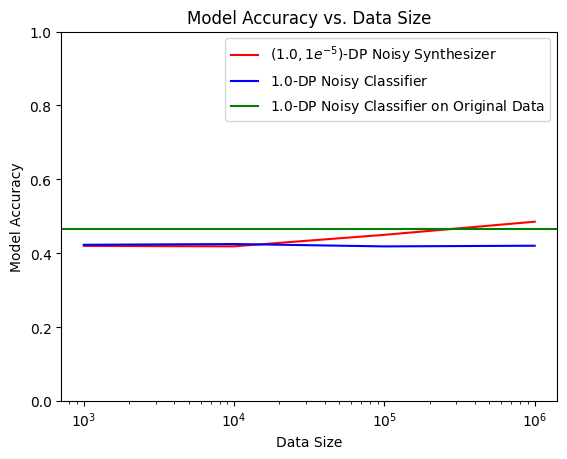

In [7]:
# Plot
plt.title("Model Accuracy vs. Data Size")
plt.xscale("log")
plt.xlabel("Data Size")
plt.ylabel("Model Accuracy")
plt.ylim(0, 1.0)

plt.plot(sample_range, noisy_synth_accuracies, color='r') # plot accuracy of dp synth
plt.plot(sample_range, noisy_tree_accuracies, color='b') # plot accuracy of dp tree
plt.axhline(dp_dtree(1.0), color='g') # plot base accuracy of model
plt.legend([r'($1.0, 1e^{-5}$)-DP Noisy Synthesizer', r'$1.0$-DP Noisy Classifier', r'$1.0$-DP Noisy Classifier on Original Data']) 
plt.show()

## Effect of epsilon on DP Model vs DP Synthetic Data Model

In [27]:
epsilons = [0.2, 0.5, 1.0, 5.0, 10.0, 25.0]
dp_dtree_acc = []
synth_acc = []
for epsilon in epsilons:
    dp_dtree_acc.append(dp_dtree(epsilon))
    
    synth = create_synthesizer(epsilon, 1e-5)
    synth_acc.append(dp_synth_dtree(synth, 1000))

Spent 0.04 epsilon on preprocessor, leaving 0.16 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 0.1 epsilon on preprocessor, leaving 0.4 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 0.2 epsilon on preprocessor, leaving 0.8 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 1.0 epsilon on preprocessor, leaving 4.0 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 2.0 epsilon on preprocessor, leaving 8.0 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals
Spent 5.0 epsilon on preprocessor, leaving 20.0 for training
Fitting with 72960000 dimensions
Getting cliques
Estimating marginals


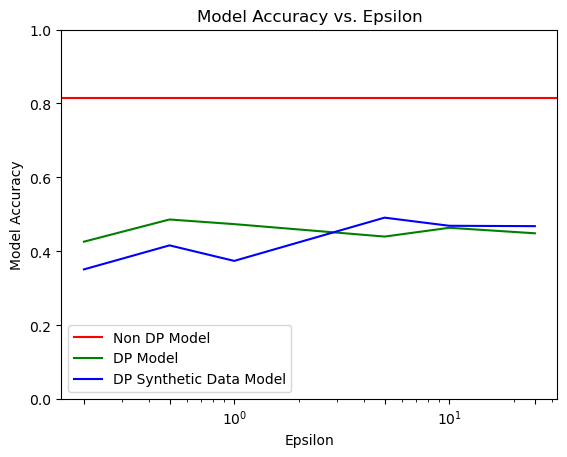

In [29]:
plt.title("Model Accuracy vs. Epsilon")
plt.xlabel("Epsilon")
plt.ylabel("Model Accuracy")
plt.ylim(0, 1.0)
plt.xscale("log")
plt.xticks(epsilons)

plt.axhline(dtree(X,y), color='r') # plot base accuracy of model
plt.plot(epsilons, dp_dtree_acc, color='g') # plot accuracy of dp decision tree
plt.plot(epsilons, synth_acc, color='b') # plot accuracy of dp synthetic data 
plt.legend([f'Non DP Model', r'DP Model', r'DP Synthetic Data Model']) 
plt.show()